In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

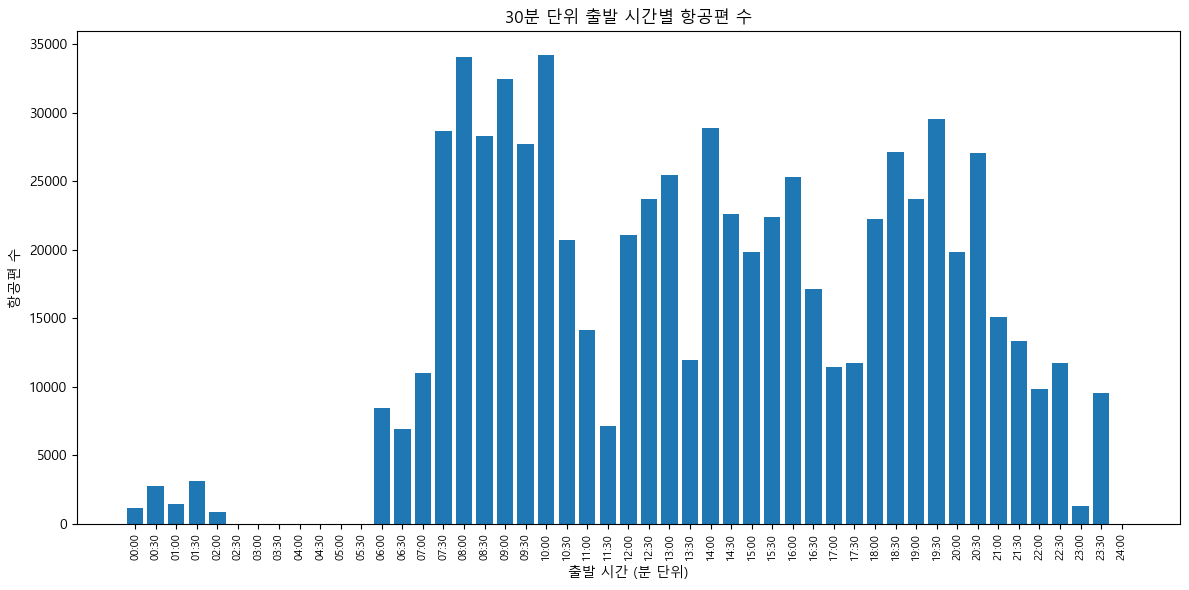

In [3]:
query = "instantrip.sql 직항 출발 시간 별 항공권 수"

# 파일 경로
file_path = './data/직항_출발_30분단위_항공권_개수.csv'

# CSV 파일 읽기
data = pd.read_csv(file_path)

# 00:00부터 24:00까지 30분 단위로 시간 문자열 생성
time_intervals = [f"{hour:02}:{minute:02}" for hour in range(25) for minute in (0, 30) if not (hour == 24 and minute != 0)]

# 데이터에 없는 시간대에 대한 항공편 수를 0으로 설정
time_dict = {time: 0 for time in time_intervals}
for idx, row in data.iterrows():
    time_dict[row['dep_sdt_30min_formatted']] = row['flight_count']

# 정렬된 시간대와 항공편 수 리스트 생성
sorted_times = list(time_dict.keys())
sorted_counts = list(time_dict.values())

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(sorted_times, sorted_counts)
plt.xlabel('출발 시간 (분 단위)')
plt.ylabel('항공편 수')
plt.title('30분 단위 출발 시간별 항공편 수')
plt.xticks(ticks=range(len(sorted_times)), labels=sorted_times, rotation=90, size=8)
plt.tight_layout()

# 그래프 보여주기
plt.show()


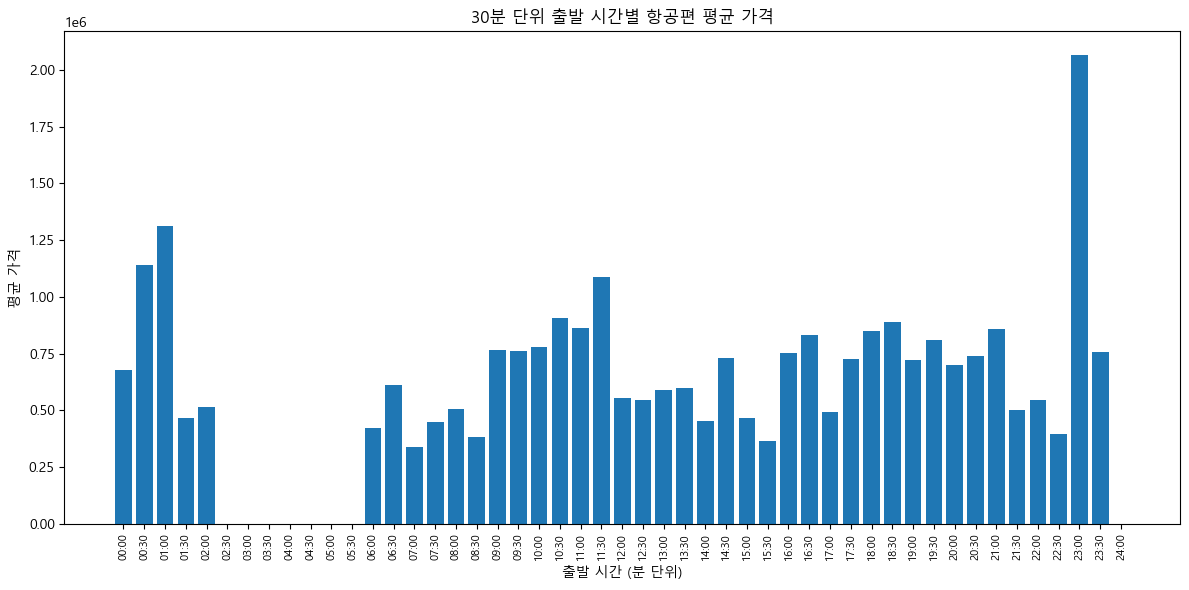

In [4]:
query = "instantrip.sql 직항_출발_30분단위__평균가격"

# 파일 경로
file_path = './data/직항_출발_30분단위__평균가격.csv'

# CSV 파일 읽기
data = pd.read_csv(file_path)

# 00:00부터 24:00까지 30분 단위로 시간 문자열 생성
time_intervals = [f"{hour:02}:{minute:02}" for hour in range(25) for minute in (0, 30) if not (hour == 24 and minute != 0)]

# 데이터에 없는 시간대에 대한 항공편 수를 0으로 설정
time_dict = {time: 0 for time in time_intervals}
for idx, row in data.iterrows():
    time_dict[row['dep_sdt_30min_formatted']] = row['avg_fare']

# 정렬된 시간대와 항공편 수 리스트 생성
sorted_times = list(time_dict.keys())
sorted_counts = list(time_dict.values())

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(sorted_times, sorted_counts)
plt.xlabel('출발 시간 (분 단위)')
plt.ylabel('평균 가격')
plt.title('30분 단위 출발 시간별 항공편 평균 가격')
plt.xticks(ticks=range(len(sorted_times)), labels=sorted_times, rotation=90, size=8)
plt.tight_layout()

# 그래프 보여주기
plt.show()


In [5]:
# 위의 그래프에서 23:30의 항공권이 가장 비싼데 통상적으로 아는 정보와 다르다.
# 아마도 남미 비행기가 가장 비싸고 23:30에 남미로 출발하면 점심쯤 도착하니까 이런 편향된 데이터가 나오지 않았을까

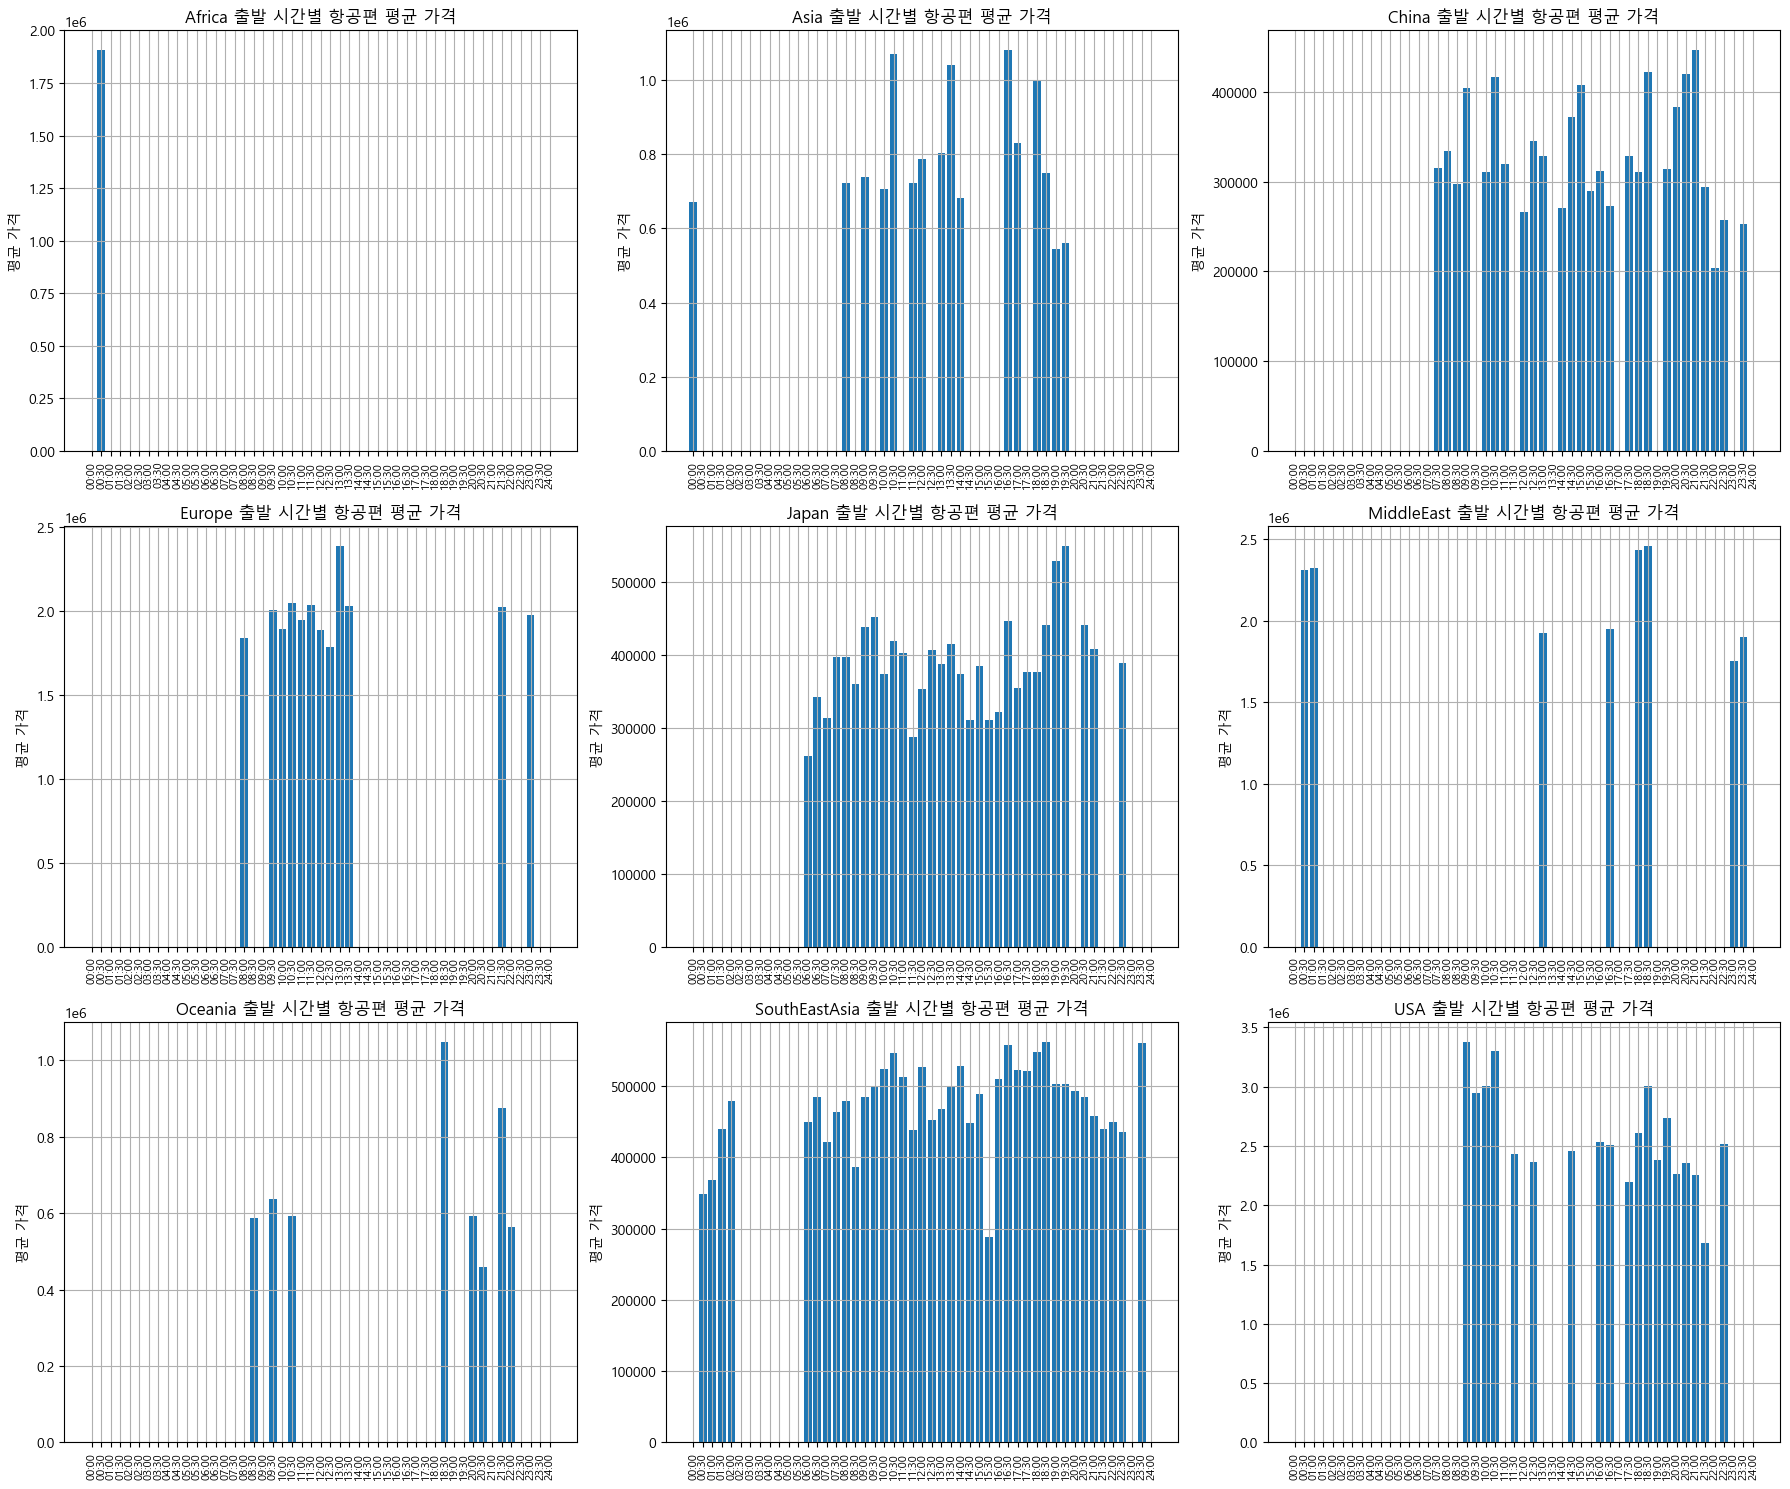

In [21]:
# partition_0(대륙)을 기준으로 따로 시각화

data = pd.read_csv('.\data\직항_대륙별_시간_평균가격.csv')
# partition_0 별로 분할
df = {}
for partition_0 in data['partition_0'].unique().tolist():
    tmp = data.loc[data['partition_0'] == partition_0]
    df[partition_0] = tmp


# 00:00부터 24:00까지 30분 단위로 시간 문자열 생성
time_intervals = [f"{hour:02}:{minute:02}" for hour in range(25) for minute in (0, 30) if not (hour == 24 and minute != 0)]

# partition_0별로 00~24시까지 누락 데이터 형식 통일
for partition_0 in df:
    full_data_values = [0] * len(time_intervals)

    for time, value in zip(df[partition_0]['dep_sdt_30min_formatted'], df[partition_0]['avg_fare']):
        index = time_intervals.index(time)
        full_data_values[index] = value
    df[partition_0] = full_data_values

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))#, sharex=True


for i, partition in enumerate(df):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].bar(time_intervals, df[partition])
    #axes[row, col].set_xlabel('출발 시간 (30분 단위)')
    axes[row, col].set_ylabel('평균 가격')
    axes[row, col].set_title(f'{partition} 출발 시간별 항공편 평균 가격')
    axes[row, col].set_xticks(range(len(time_intervals)))
    axes[row, col].set_xticklabels(time_intervals, rotation=90, size=8)
    #axes[row, col].set_yticks(range(0,5000000,500000))
    axes[row, col].grid(True)
    
plt.tight_layout()
#plt.subplots_adjust(hspace=0.5, wspace=0.4, bottom=0.3)  # 서브플롯 간의 수직 간격, 수평 간격 및 하단 마진 조정
plt.show()

In [7]:
# 대륙별 가격 분포
data = pd.read_csv('./data/직항_가격.csv')
data['partition_0'].unique()

array(['SouthEastAsia', 'USA', 'Japan', 'China', 'MiddleEast', 'Oceania',
       'Asia', 'Europe', 'Africa'], dtype=object)

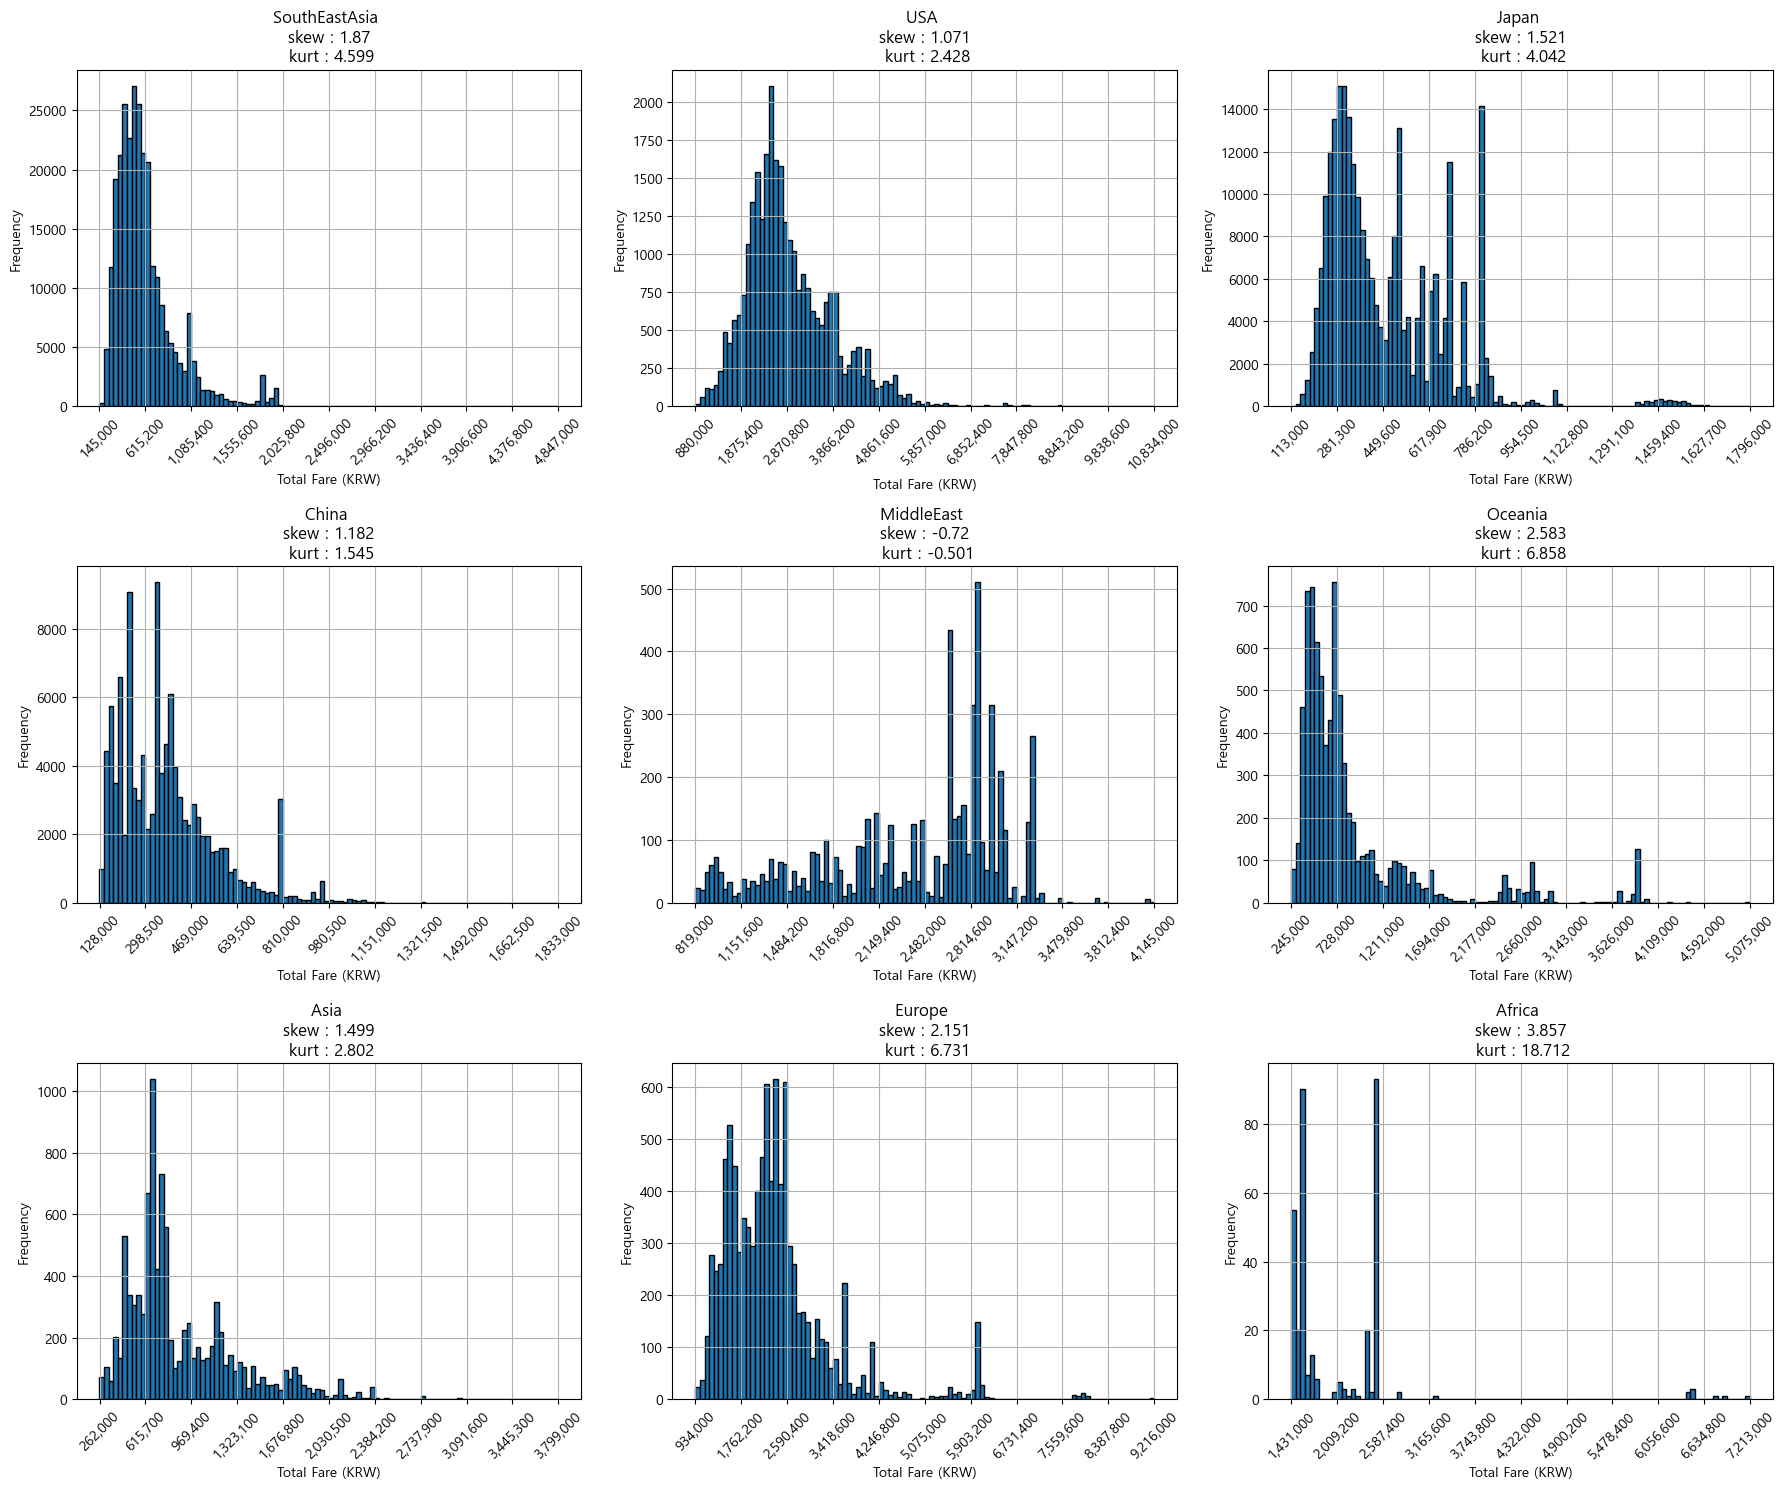

In [8]:
import matplotlib.pyplot as plt
import numpy as np

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))

for i, partition in enumerate(data['partition_0'].unique()):
    row = i // n_cols
    col = i % n_cols
    partition_data = data.loc[data["partition_0"] == partition]['total_fare']
    max_fare = partition_data.max()
    min_fare = partition_data.min()
    
    # Round the min and max fare to the nearest 1000
    min_fare = np.round(min_fare, -3)
    max_fare = np.round(max_fare, -3)
    
    # Calculate the bin width and xticks interval
    bin_width = (max_fare - min_fare) // 10
    xticks_interval = bin_width  
    
    axes[row, col].hist(partition_data, bins=100, edgecolor='black')
    axes[row, col].set_title(f"{partition} \n skew : {round(partition_data.skew(),3)} \n kurt : {round(partition_data.kurt(),3)}")
    axes[row, col].set_xlabel('Total Fare (KRW)')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_xticks(np.arange(min_fare, max_fare + xticks_interval, xticks_interval))
    axes[row, col].set_xticklabels([f'{int(x):,}' for x in np.arange(min_fare, max_fare + 1, xticks_interval)], rotation=45)
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()


C:\Users\hcho0\AppData\Local\Temp\ipykernel_9360\3150188923.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = data.groupby('partition_0').apply(remove_top_10_percent, column='total_fare').reset_index(drop=True)


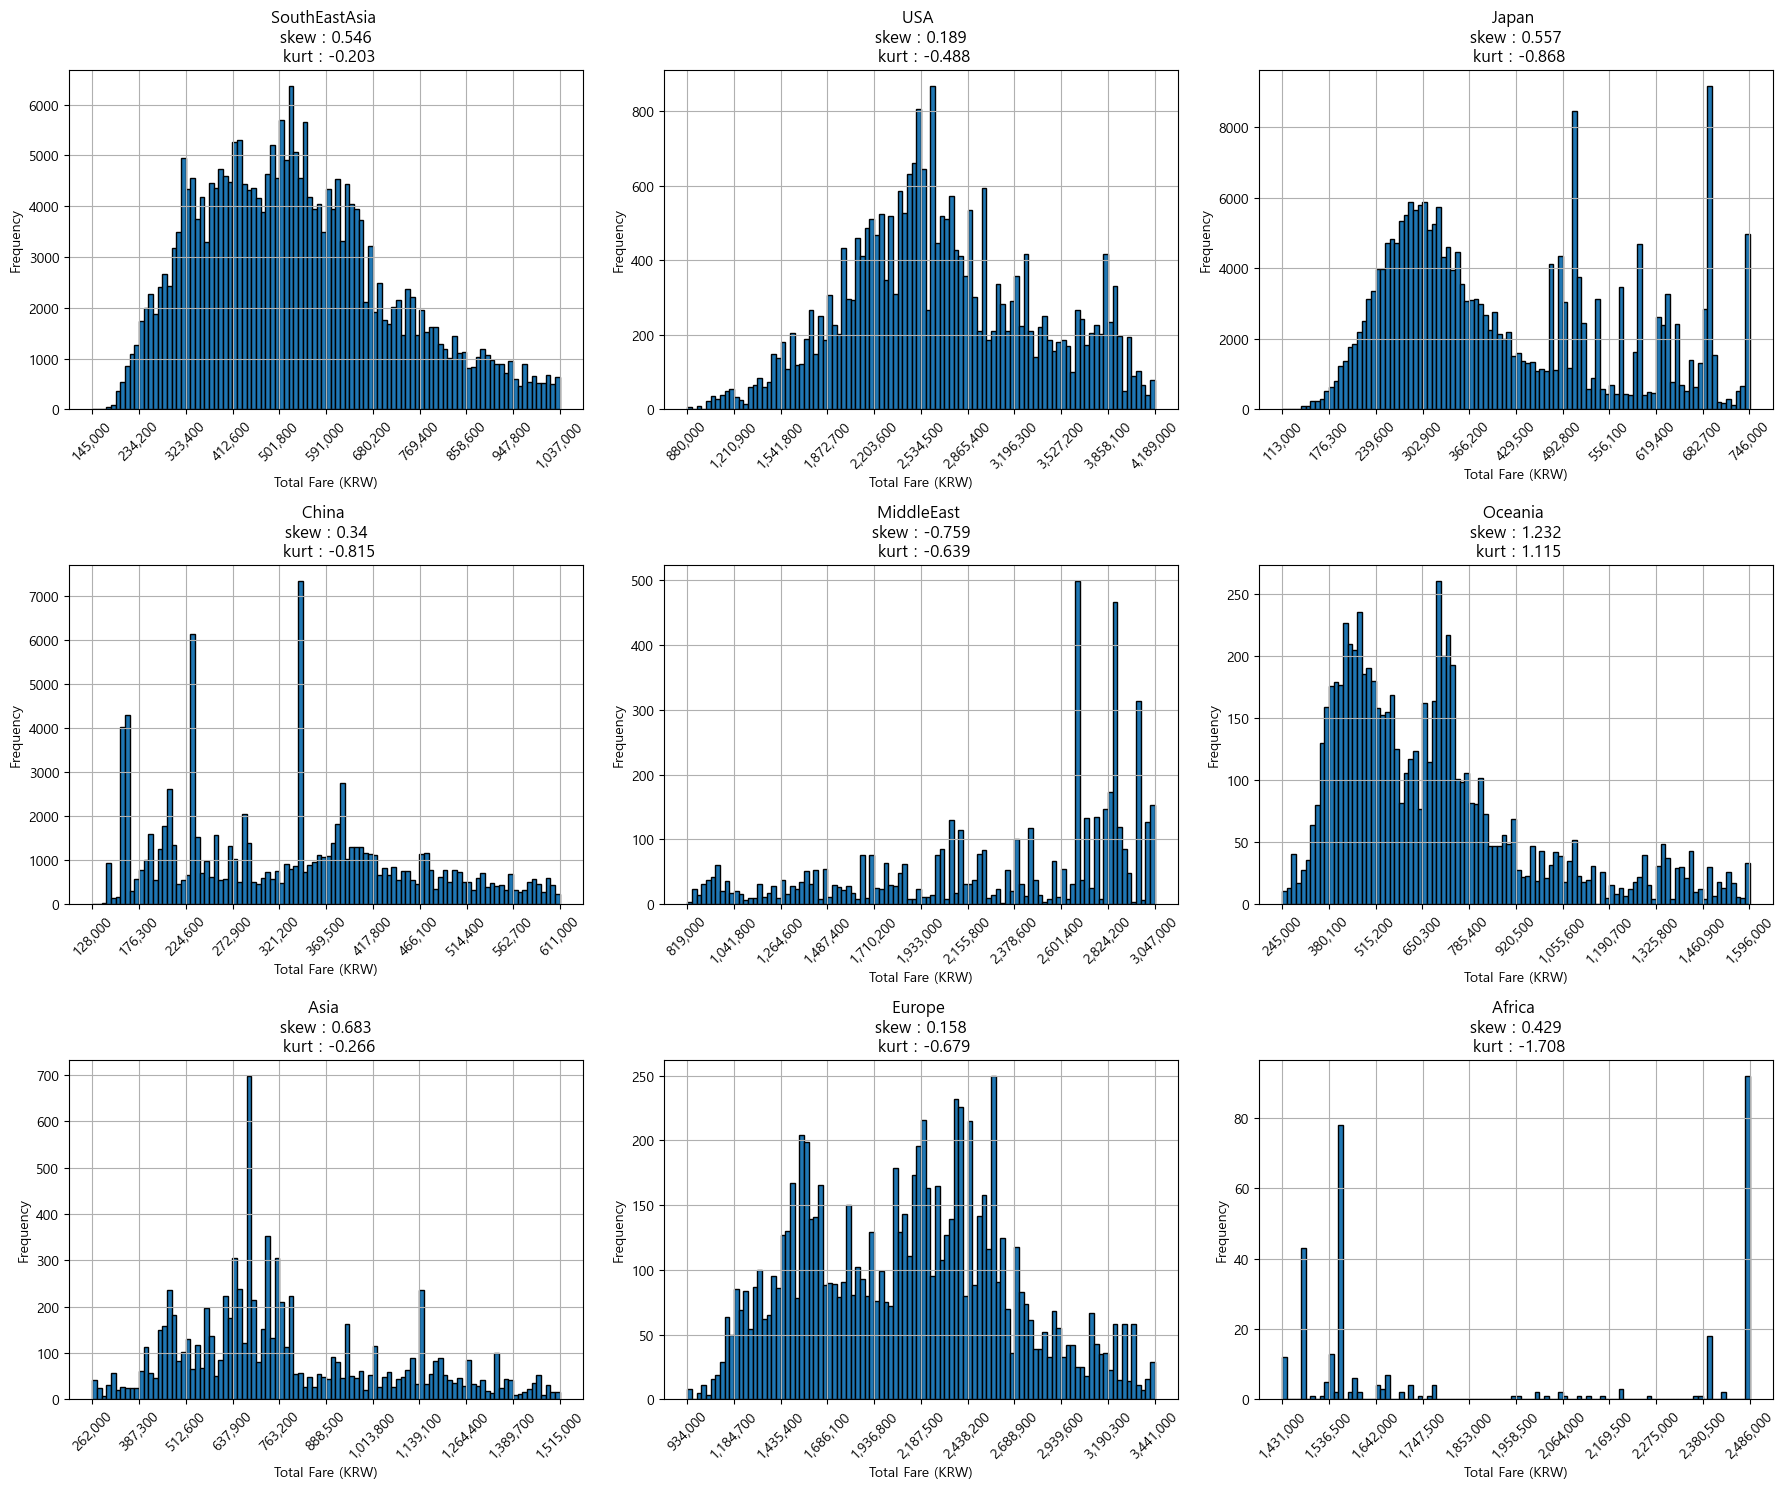

In [9]:
def remove_top_10_percent(df, column):
    threshold = df[column].quantile(0.90)
    return df[df[column] <= threshold]

# 각 partition_0 그룹에 대해 상위 20%를 제거
filtered_data = data.groupby('partition_0').apply(remove_top_10_percent, column='total_fare').reset_index(drop=True)

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))

for i, partition in enumerate(data['partition_0'].unique()):
    row = i // n_cols
    col = i % n_cols
    partition_filtered_data = filtered_data.loc[filtered_data["partition_0"] == partition]['total_fare']
    max_fare = partition_filtered_data.max()
    min_fare = partition_filtered_data.min()
    
    # Round the min and max fare to the nearest 1000
    min_fare = np.round(min_fare, -3)
    max_fare = np.round(max_fare, -3)
    
    # Calculate the bin width and xticks interval
    bin_width = (max_fare - min_fare) // 10
    xticks_interval = bin_width  
    
    axes[row, col].hist(partition_filtered_data, bins=100, edgecolor='black')
    axes[row, col].set_title(f"{partition} \n skew : {round(partition_filtered_data.skew(),3)} \n kurt : {round(partition_filtered_data.kurt(),3)}")
    axes[row, col].set_xlabel('Total Fare (KRW)')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_xticks(np.arange(min_fare, max_fare + xticks_interval, xticks_interval))
    axes[row, col].set_xticklabels([f'{int(x):,}' for x in np.arange(min_fare, max_fare + 1, xticks_interval)], rotation=45)
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

C:\Users\hcho0\AppData\Local\Temp\ipykernel_9360\1278934530.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = data.groupby('partition_0').apply(remove_top_10_percent, column='total_fare').reset_index(drop=True)


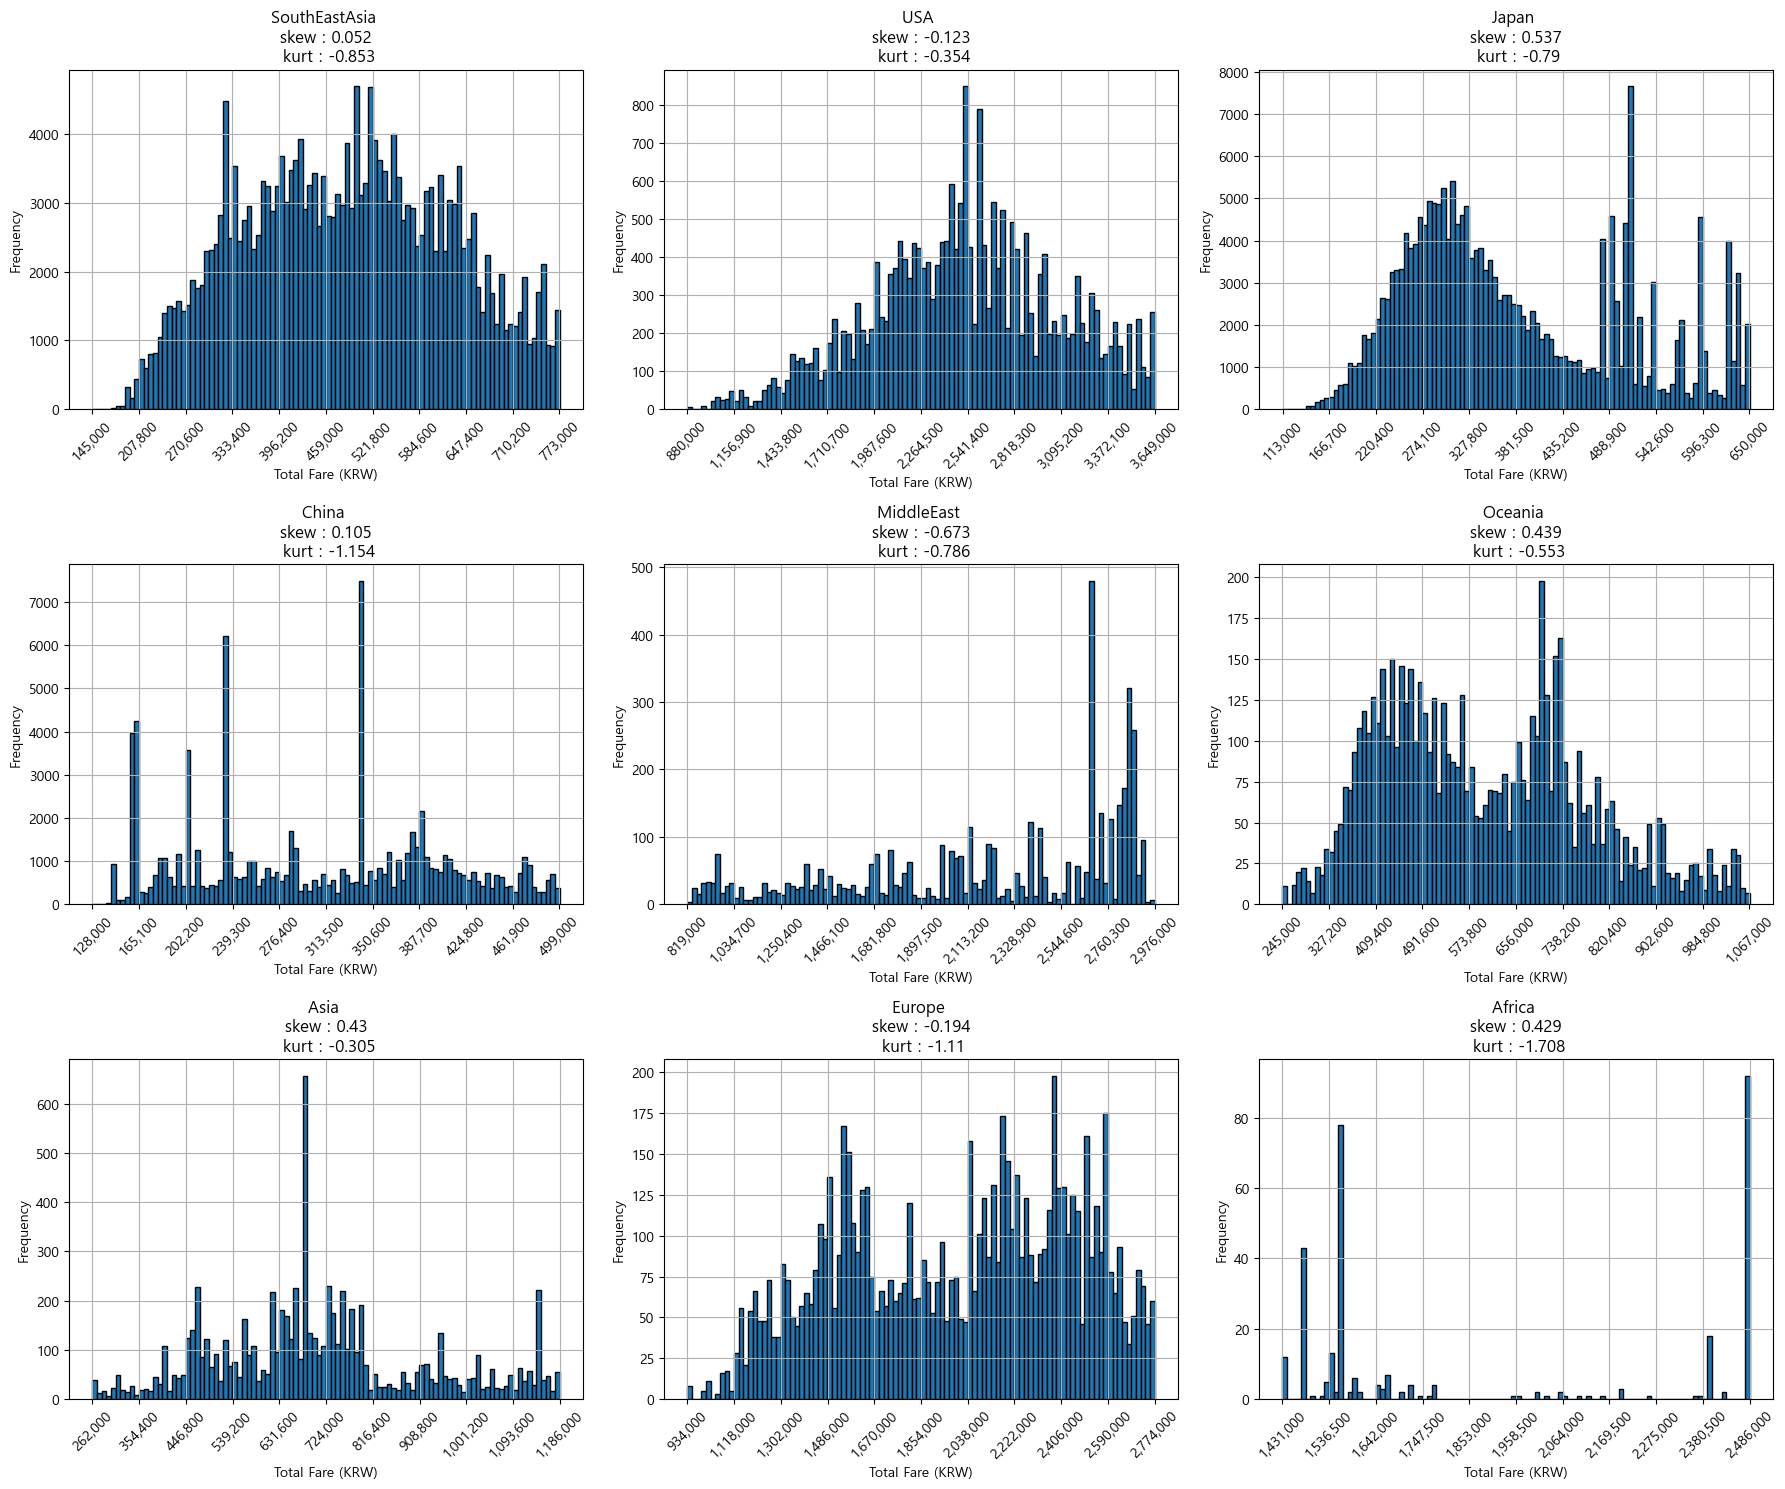

In [10]:
def remove_top_10_percent(df, column):
    threshold = df[column].quantile(0.80)
    return df[df[column] <= threshold]

# 각 partition_0 그룹에 대해 상위 20%를 제거
filtered_data = data.groupby('partition_0').apply(remove_top_10_percent, column='total_fare').reset_index(drop=True)

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))

for i, partition in enumerate(data['partition_0'].unique()):
    row = i // n_cols
    col = i % n_cols
    partition_filtered_data = filtered_data.loc[filtered_data["partition_0"] == partition]['total_fare']
    max_fare = partition_filtered_data.max()
    min_fare = partition_filtered_data.min()
    
    # Round the min and max fare to the nearest 1000
    min_fare = np.round(min_fare, -3)
    max_fare = np.round(max_fare, -3)
    
    # Calculate the bin width and xticks interval
    bin_width = (max_fare - min_fare) // 10
    xticks_interval = bin_width  
    
    axes[row, col].hist(partition_filtered_data, bins=100, edgecolor='black')
    axes[row, col].set_title(f"{partition} \n skew : {round(partition_filtered_data.skew(),3)} \n kurt : {round(partition_filtered_data.kurt(),3)}")
    axes[row, col].set_xlabel('Total Fare (KRW)')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_xticks(np.arange(min_fare, max_fare + xticks_interval, xticks_interval))
    axes[row, col].set_xticklabels([f'{int(x):,}' for x in np.arange(min_fare, max_fare + 1, xticks_interval)], rotation=45)
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

In [13]:
# 가격 상위 20퍼 데이터를 제거함으로서 데이터 치우침 해결

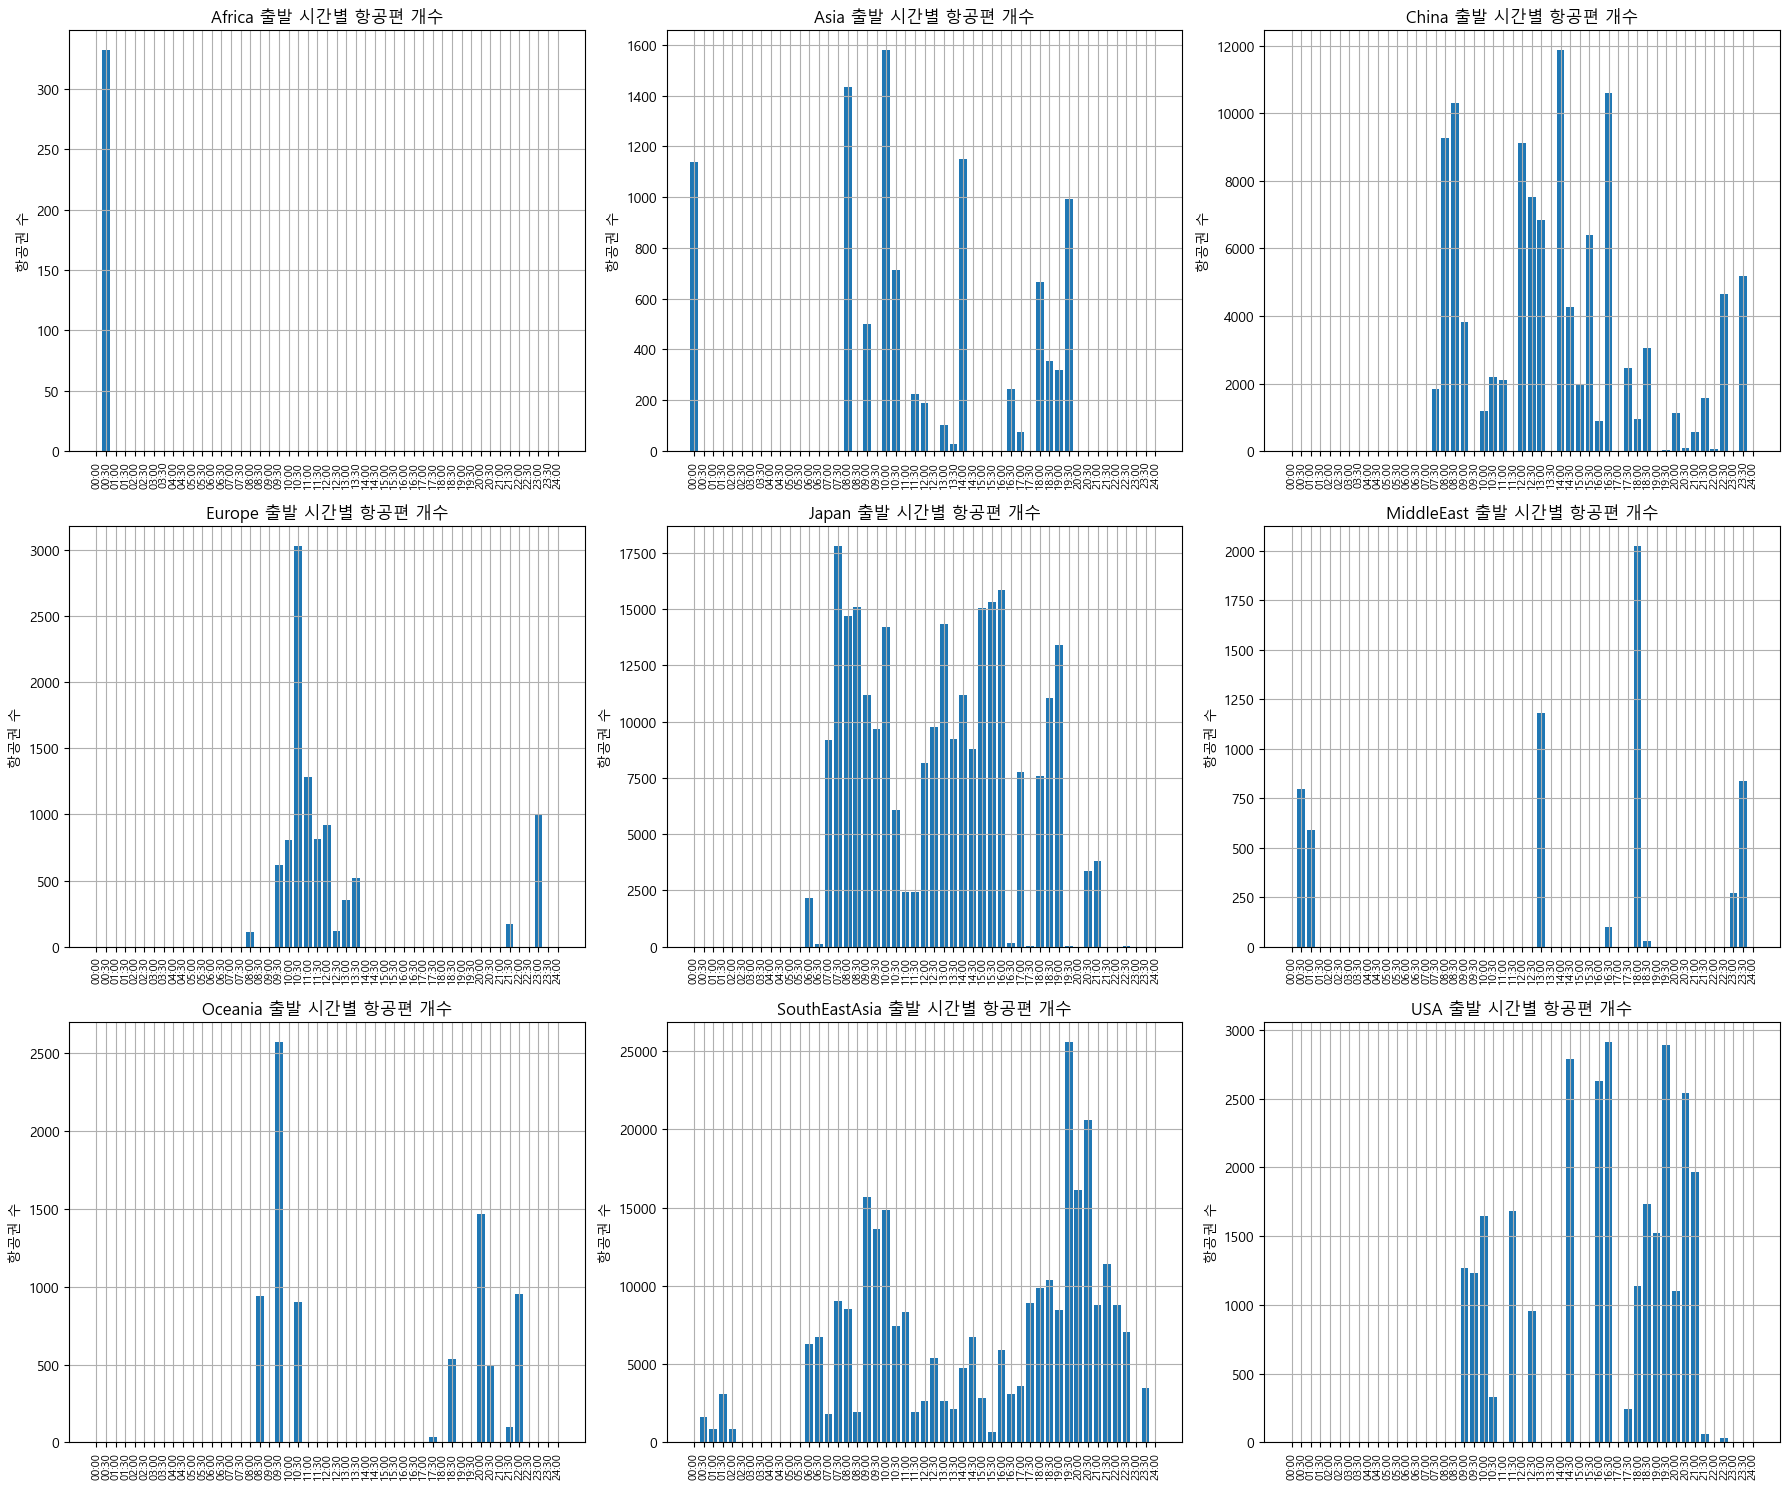

In [19]:
data = pd.read_csv('./data/직항_출발_30분단위_대륙별_항공권_개수.csv')

# partition_0 별로 분할
df = {}
for partition_0 in data['partition_0'].unique().tolist():
    tmp = data.loc[data['partition_0'] == partition_0]
    df[partition_0] = tmp


# 00:00부터 24:00까지 30분 단위로 시간 문자열 생성
time_intervals = [f"{hour:02}:{minute:02}" for hour in range(25) for minute in (0, 30) if not (hour == 24 and minute != 0)]

# partition_0별로 00~24시까지 누락 데이터 형식 통일
for partition_0 in df:
    full_data_values = [0] * len(time_intervals)

    for time, value in zip(df[partition_0]['dep_sdt_30min_formatted'], df[partition_0]['cnt']):
        index = time_intervals.index(time)
        full_data_values[index] = value
    df[partition_0] = full_data_values

n_rows, n_cols = 3, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15))#, sharex=True


for i, partition in enumerate(df):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].bar(time_intervals, df[partition])
    #axes[row, col].set_xlabel('출발 시간 (30분 단위)')
    axes[row, col].set_ylabel('항공권 수')
    axes[row, col].set_title(f'{partition} 출발 시간별 항공편 개수')
    axes[row, col].set_xticks(range(len(time_intervals)))
    axes[row, col].set_xticklabels(time_intervals, rotation=90, size=8)
    # axes[row, col].set_yticks(range(0,5000000,500000))
    axes[row, col].grid(True)
    
plt.tight_layout()
#plt.subplots_adjust(hspace=0.5, wspace=0.4, bottom=0.3)  # 서브플롯 간의 수직 간격, 수평 간격 및 하단 마진 조정
plt.show()


